# Combination
Combines Stage 1-Binary Classifier and Stage 2-Image Consistency Estimator
- Must have saved models to use

In [0]:
# Importing useful libraries
import math
import os
import random
import torch
import cv2
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from torchsummary import summary
from torchvision import datasets, models, transforms

from datetime import datetime
from torch.utils.data import DataLoader, Dataset, IterableDataset
from tqdm.auto import tqdm
from tqdm.notebook import tqdm as new_tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from google.colab.patches import cv2_imshow
import numpy as np
import copy
import gc #gc is garbage collector.
gc.collect()
torch.cuda.empty_cache()

#used in feature extraction
from itertools import accumulate, combinations  # to cumulatively sum a list. used in this class. 
                                  # transfer this to main import at the top of the notebook.
import bisect #bisect needed for finding index of the first element bigger than given input.
import random # needed for shuffling

In [2]:
# Mount Shared Drive for project to /content/drive/ folder
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Global Variables

In [4]:
# Torch variables
global_dtype = torch.float32  #Changed on purpose to save memory issues.
global_device = "cuda"
local_device="cpu"
print(f"We will be using global dtype = {global_dtype} and global device = {global_device}")
if torch.cuda.is_available():
  print ("CUDA is available!")

"""
Have been fixed. Do not change without a reason!
"""
# Image transform variables
image_resize = 224 #Resize all images to be 224 x 224
image_crop = 224 
image_center_crop = 256
image_rotate = 10 # Rotate images randomly +/- 10 degrees

# The following mean and std are calculated on ImageNet dataset and all pre-trained PyTorch models (like resnet-18)
# expect input images to be normalized using this mean and std values. So we are correct in using these values.
image_mean = torch.tensor([0.485, 0.456, 0.406]) 
image_std= torch.tensor([0.229, 0.224, 0.225]) 

We will be using global dtype = torch.float32 and global device = cuda
CUDA is available!


In [0]:
# This is needed even if we directly load the loaders from saved files.
# We will use this class to create datasets containing image tensors and their labels
def filter_fun(x): #keep it outside.
  return gaussian_filter(x,sigma=1.2 , mode='nearest')

class ImageTensorDataset(Dataset):
  # We do not need transform member since we preprocessed already
  def __init__ (self, image_tensors, labels, augment=False):
    self.image_tensors = image_tensors
    self.labels = labels

    self.transform_augment = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((300,300)),
                                                 transforms.RandomHorizontalFlip(p=1),
                                                 transforms.RandomRotation(20),
                                                 transforms.CenterCrop(256),                                                 
                                                 transforms.RandomCrop(224),                                                 
                                                 transforms.Lambda(filter_fun),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=image_mean, std=image_std)])
    self.transform = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=image_mean, std=image_std)])
    self.augment = augment #a flag indicating whether we want or not the augmentation.

  
  # Used to index the dataset [#]
  def __getitem__(self, index):
    if self.augment:
        image_tensor = self.transform_augment(self.image_tensors[index].cpu())#.cuda()
        label = self.labels[index]       
    else: 
        image_tensor = self.transform(self.image_tensors[index].cpu())#.cuda()
        label = self.labels[index]
    return image_tensor, label

  # Used to count how many tensors are in the dataset
  def __len__(self):
    return len(self.image_tensors)

# This is needed even if we directly load the loaders from saved files.
# We will use this class to create datasets containing image tensors and their labels
class ImageTensorDataset_noaugment(Dataset):
  # We do not need transform member since we preprocessed already
  def __init__ (self, image_tensors, labels, augment=False):
    self.image_tensors = image_tensors
    self.labels = labels    
    
  # Used to index the dataset [#]
  def __getitem__(self, index):
    image_tensor = self.image_tensors[index]#self.transform()#.cuda()
    label = self.labels[index]
    return image_tensor, label

  # Used to count how many tensors are in the dataset
  def __len__(self):
    return len(self.image_tensors)

#Load DataLoaders




In [0]:
train_loader_file="/content/drive/Shared drives/EECS504/Saved_Objects/train_loader_256_2020-04-12_221334.pt"
val_loader_file="/content/drive/Shared drives/EECS504/Saved_Objects/val_loader_256_2020-04-12_221512.pt"
test_loader_file="/content/drive/Shared drives/EECS504/Saved_Objects/test_loader_256_2020-04-12_221526.pt"

# Loading the DataLoaders:
train_loader = torch.load(train_loader_file)
val_loader = torch.load(val_loader_file)
test_loader = torch.load(test_loader_file)

In [8]:
print(len(val_loader),len(test_loader))

5 10


# Network Setup

## Feature Extractor

In [9]:
ratio = [60,20,20] # These are percentages. Summation must be 100%.
batch_size = 256
process_batch = 32  # Batches of images are passed one-by-one through the feature extractor and at the end all features are concatenated.

#Feature Extractor: It uses pre-trained ResNet-18 as initial layers of our neural network to extract features of the input images.
# Input image size = N x 3 x reshape_size x reshape_size.

class FeatureExtractor(nn.Module):
  """
  Image feature extraction with ResNet-18.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()

    resnet_original = models.resnet18(pretrained=True)
    self.resnet = nn.Sequential(*list(resnet_original.children())[:-1]) #Use only the first 13 layers [0-12].

    self.resnet.cuda()
    if verbose:
      summary(self.resnet.cuda(), (3, reshape_size, reshape_size))
    
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x32x32
    
    Outputs:
    - feat: Image feature, of shape Nx___ (pooled) or Nx____x houtx wout
    """
    # Batches of images are passed one-by-one through the feature extractor and at the end all features are concatenated.
    # Since the feature extractor contains many layers and millions of parameters, input tensors must be of limited dimensions to avoid memory overflow.
    num_img = img.shape[0]
    img_prepro = img.to(device=global_device,dtype=global_dtype)

    feat = []
    for b in range(math.ceil(num_img/process_batch)):   
      feat.append(self.resnet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat.to(device=global_device,dtype=global_dtype)

feat_extr = FeatureExtractor(verbose=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64

### Network-1: Image Classifier

In [0]:
# This is our network which we will train. Input to this network would be extracted features of the images through the FeatureExtractor.
""" NOTE: Since feature_extractor is defined in init() below, algorithm will re-train it!! 
    
"""

class Image_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.feat_extr = FeatureExtractor(reshape_size=image_resize) # COMMMENT THIS OUT!
    self.fl= nn.Flatten()
    self.fc1 = nn.Linear(512,128)
    self.relu1=nn.LeakyReLU(negative_slope=0.01)
    self.dropout1 = nn.Dropout(p=0.7)#nn.Dropout2d()
    self.fc2 = nn.Linear(128,1) #maps to final 1 output score to be used in predicting real or fake image.
  
  def forward(self, x):  # forward always defines connectivity
    self.cuda()
    local_dtype=x.dtype
    local_device=x.device
    
    # i) Image feature extraction
    features=self.feat_extr(x).squeeze()  
    out1=self.fc2(self.dropout1(self.relu1(self.fc1(features))))
    scores=(out1).squeeze()
    return scores

gc.collect()
torch.cuda.empty_cache()

### Network-2: Consistency Estimator

In [12]:
class Estimator(nn.Module):
  """
  Estimates consistency between pairs of patches. 

  """
  def __init__(self,verbose=False):
    super().__init__()
    #input N x 64 x H x W . Typically  H x W = 28 x 28
    self.fc1=nn.Linear(512, 8)
    self.lr=nn.LeakyReLU(0.02)
    self.fc2=nn.Linear(8,2)

    nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu' )
    nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')
    #nn.init.kaiming_normal_(self.lin.weight, mode='fan_in', nonlinearity='leaky_relu')
    
    self.estm =nn.Sequential( 
    nn.Conv2d(64, 128, (3,3),stride=2,padding=1),
    nn.BatchNorm2d(128),  #Nx128x28x28  - Remove this first BN layer if it causes CUDA memory outage.
    nn.LeakyReLU(0.02),
    nn.MaxPool2d((3,3),stride=2,padding=1), #downsample -> 15x15

    nn.Conv2d(128, 256, (3,3),stride=1,padding=1),
    
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.02),
    nn.MaxPool2d((3,3),stride=2,padding=1),  #downsample -> 8x8

    nn.Conv2d( 256,512, (3,3),stride=1,padding=1),
    
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.02),
    nn.MaxPool2d((3,3),stride=2,padding=1), #downsample -> 4x4   

    nn.AdaptiveAvgPool2d((1,1)),  #downsample -> 1x1
    # N x 128 x 1 x 1 
    nn.Flatten()) #-> N x 128
    
    #initialize:
    for m in self.estm.modules():
      if isinstance(m, nn.Conv2d):
        print("conv",m)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', a=0.02, nonlinearity='leaky_relu')

      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        # Recommended to initialize batch-norm like this.
        print("batch-norm",m)
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
      elif isinstance(m,nn.Linear):
        print("linear",m)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', a=0.02, nonlinearity='leaky_relu')    

    if verbose==True:
      summary(self.estm.cuda(), (64, 28, 28),device=global_device)

  def forward(self, x):  # Siamese Structure  x = Nx (64*2)x  28x28, passed 64 channels at once.
    self.cuda()
    local_dtype=x.dtype
    local_device=x.device
    
    out_p1=self.lr(self.fc1(self.estm(x[:,:64,:,:]).squeeze().squeeze()))  #Nx32
    out_p2=self.lr(self.fc1(self.estm(x[:,64:,:,:]).squeeze().squeeze()))  #Nx32
    out=torch.abs(out_p2-out_p1)  # Nx32   

    scores=self.fc2(out) #Nx2

    scores=scores.to(device=local_device,dtype=local_dtype) 
    return scores

feat_extr = FeatureExtractor(verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Truncated Feature Extractor - a Fixed Network used to extract Feature-map:


In [16]:
# Feature Extractor: It uses pre-trained ResNet-18 as initial layers of our neural network to extract features of the input images.
# Input image size = N x 3 x reshape_size x reshape_size.

class Trunc_FeatureExtractor(nn.Module):
  """
  Image feature extraction with truncated ResNet-18.
  This network has been correctly implemented.
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False,vis=0):
    super().__init__()
    
    self.resnet_original = models.resnet18(pretrained=True)      
    list1=list(self.resnet_original.children())[0:5]    
    list2=[list1[0]]
    list2.append(nn.Sequential(*list1[2:5]))   
    
    self.tr_resnet = nn.Sequential(*list2)

    self.tr_resnet.cuda()
    if verbose:
      summary(self.tr_resnet.cuda(), (3, reshape_size, reshape_size), device=global_device)
    
    del self.resnet_original #no need.
  
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x32x32
    
    Outputs:
    - feat: Image feature, of shape Nx___ (pooled) or Nx____x houtx wout
    """
    # Batches of images are passed one-by-one through the feature extractor and at the end all features are concatenated.
    # Since the feature extractor contains many layers and millions of parameters, input tensors must be of limited dimensions to avoid memory overflow    
    with torch.no_grad(): #We are extracting features for further processing. No training of the feature extractor.
      self.tr_resnet.cuda()
      num_img = img.shape[0]
      img_prepro = img.to(device=global_device,dtype=global_dtype)

      feat = []
      for b in range(math.ceil(num_img/process_batch)):   
        feat.append(self.tr_resnet(img_prepro[b*process_batch:(b+1)*process_batch]
                                ).squeeze(-1).squeeze(-1)) # forward and squeeze
      feat = torch.cat(feat)
      
      if verbose:
        print('Output feature shape: ', feat.shape)
      
      return feat.to(device=global_device,dtype=global_dtype)

trunc_feat_extr = Trunc_FeatureExtractor(verbose=True) 
print(trunc_feat_extr.tr_resnet)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,864
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
       BasicBlock-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

#Patch - Triplets Extraction: 


In [0]:
class Extractor():
  def shuffle_all_indices(self,N): #A helper function to shuffle indices for inconsistent patch-pairs.
    arr = list(range(N))
    error_list=[]
    for i in range(len(arr)):
      if i > 0:
        rand_idx = random.randint(0, i-1)
        arr[i], arr[rand_idx] = arr[rand_idx], arr[i]
    
    #check if any index is at the same place as before shuffling.   
    for i in range(len(arr)):
      if arr[i]== i:
        error_list.append([i,arr[i]])

    print("error in shuffling, if any:",error_list)    
    return arr


  def patch_extr(self,features, patch_sizes,num_patches,out_size=(28,28),verbose=False):
    """
    Happens on CPU to save GPU.
    In:
    features - feature-map from the feature extractor, of size N_in xC x H XW
    patch_sizes - a list of patch_sizes
    num_patches - a list of number of patches for each patch_size, must
                  be of the same length as patch_sizes
    out_size - a fixed output size (H_out,W_out). Each patch will be of different size, so it 
              will be resized to out_size before feeding into the next network.

    Standard Ex.:
    patch_sizes=[(28,14),(28,28),(40,40)]
    num_patches=[1,1,1]
    out_size=(30,30)
    

    Out:
    patches - a list, where each entry is a tensor of image patch of size (N_in*num_patches[i]) x C x H_out x W_out
          Thus, length of this list = length of patch_sizes = number of different size of patches.
    patches[i] has the structure given below: (now simplified to N_in x num_patches[i] x C x H_out x W_out)
    
    n0,n1,n2,...= input feature indices (= feature[0],feature[1],...)
    out[i] is composed of:
    patch[n0][first patch of the first_patch_size]
    patch[n0][second patch of the first_patch_size]
    .
    .
    .
    patch[n0][(num_patch[0])th patch of the first_patch_size]

    patch[n1][first patch of the first_patch_size]
    patch[n1][second patch of the first_patch_size]
    .
    .
    .
    patch[n1][(num_patch[0])th patch of the first_patch_size]

    .
    .
    .
    Then the second_patch_size and so on.
    """
    with torch.no_grad():  #otherwise computes grad-function - unnecessary.

      assert len(patch_sizes)==len(num_patches), "Mismatch in the length of  patch_sizes and num_patches!"
      print(features.shape, "\n \n")
      
      self.patch_sizes = patch_sizes 
      self.num_patches= num_patches
      N_in,C,H,W= features.shape
      N_out=N_in*sum(num_patches)
      H_out=out_size[0]
      W_out=out_size[1]
    
      patches=[]
      i=0
      for i,psize in enumerate(patch_sizes):
        idxh0 = torch.randint(0,  H-psize[0]+1,(N_in*num_patches[i],)).reshape((N_in,num_patches[i]))
        idxh1 = idxh0 + psize[0]   

        idxw0 =  torch.randint(0, W-psize[1]+1,(N_in*num_patches[i],)).reshape((N_in,num_patches[i]))
        idxw1 = idxw0 + psize[1]

        patch_tensor=torch.empty((N_in*num_patches[i],C,psize[0],psize[1]))
        pid=0 #patch_id for a particular patch-size, iterated over all n, for num_patches times.
        for n in range(N_in): # for each feature map
          for k in range(num_patches[i]): # for each patch among num_patches patches
            
            patch_tensor[pid]=features[n,:,idxh0[n,k]:idxh1[n,k],idxw0[n,k]:idxw1[n,k]].reshape(-1,psize[0],psize[1])

            pid +=1

        if psize[0] != out_size[0] or psize[1] != out_size[1]:
          patch=F.interpolate(patch_tensor,size=out_size,mode='bilinear',align_corners=True)
        else:
          patch=patch_tensor
        
        patch=patch.reshape(N_in,num_patches[i],C,H_out,W_out)

        patches.append(patch)

      return patches   

  def patch_extr_fixed(self,features, patch_sizes,num_patches,out_size=(28,28),verbose=False):
    """
    Happens on CPU to save GPU.
    In:
    features - feature-map from the feature extractor, of size N_in xC x H XW
    patch_sizes - a list of patch_sizes
    num_patches - a list of number of patches for each patch_size, must
                  be of the same length as patch_sizes
    out_size - a fixed output size (H_out,W_out). Each patch will be of different size, so it 
              will be resized to out_size before feeding into the next network.

    Standard Ex.:
    patch_sizes=[(28,14),(28,28),(40,40)]
    num_patches=[1,1,1]
    out_size=(30,30)
    

    Out:
    patches - a list, where each entry is a tensor of image patch of size (N_in*num_patches[i]) x C x H_out x W_out
          Thus, length of this list = length of patch_sizes = number of different size of patches.
    patches[i] has the structure given below: (now simplified to N_in x num_patches[i] x C x H_out x W_out)
    
    n0,n1,n2,...= input feature indices (= feature[0],feature[1],...)
    out[i] is composed of:
    patch[n0][first patch of the first_patch_size]
    patch[n0][second patch of the first_patch_size]
    .
    .
    .
    patch[n0][(num_patch[0])th patch of the first_patch_size]

    patch[n1][first patch of the first_patch_size]
    patch[n1][second patch of the first_patch_size]
    .
    .
    .
    patch[n1][(num_patch[0])th patch of the first_patch_size]

    .
    .
    .
    Then the second_patch_size and so on.
    """
    with torch.no_grad():  #otherwise computes grad-function

      assert len(patch_sizes)==len(num_patches), "Mismatch in the length of  patch_sizes and num_patches!"
      print(features.shape, "\n \n")
      
      self.patch_sizes = patch_sizes 
      self.num_patches= num_patches
      N_in,C,H,W= features.shape
      N_out=N_in*sum(num_patches)
      H_out=out_size[0]
      W_out=out_size[1]
      

      patches=[]
      i=0
      psize = self.patch_sizes[0]
      idxh0 = [0, 0, 28, 28, 14]
      idxh1 = [28, 28, 56, 56, 42]

      idxw0 = [0, 28, 0, 28, 14]
      idxw1 = [28, 56, 28, 56, 42]
      

      i=0
      patch=torch.empty((N_in*num_patches[i],C,psize[0],psize[1]))#,device=global_device)
      pid=0 #patch_id for a particular patch-size, iterated over all n, for num_patches times.
      for n in range(N_in): # for each feature map
        for k in range(num_patches[i]): # for each patch among num_patches patches
          
          patch[pid]=features[n,:,idxh0[k]:idxh1[k],idxw0[k]:idxw1[k]].reshape(-1,psize[0],psize[1])

          pid +=1

      patch=patch.reshape(N_in,num_patches[i],C,H_out,W_out)  # reshape(N_in x num_patches[i] x C x H_out x W_out)

      patches.append(patch)
      return patches    

  def patch_extr_40(self,features, patch_sizes,num_patches,out_size=(28,28),verbose=False):
    """
    Happens on CPU to save GPU.
    In:
    features - feature-map from the feature extractor, of size N_in xC x H XW
    patch_sizes - a list of patch_sizes
    num_patches - a list of number of patches for each patch_size, must
                  be of the same length as patch_sizes
    out_size - a fixed output size (H_out,W_out). Each patch will be of different size, so it 
              will be resized to out_size before feeding into the next network.

    Standard Ex.:
    patch_sizes=[(28,14),(28,28),(40,40)]
    num_patches=[1,1,1]
    out_size=(30,30)
    

    Out:
    patches - a list, where each entry is a tensor of image patch of size (N_in*num_patches[i]) x C x H_out x W_out
          Thus, length of this list = length of patch_sizes = number of different size of patches.
    patches[i] has the structure given below: (now simplified to N_in x num_patches[i] x C x H_out x W_out)
    
    n0,n1,n2,...= input feature indices (= feature[0],feature[1],...)
    out[i] is composed of:
    patch[n0][first patch of the first_patch_size]
    patch[n0][second patch of the first_patch_size]
    .
    .
    .
    patch[n0][(num_patch[0])th patch of the first_patch_size]

    patch[n1][first patch of the first_patch_size]
    patch[n1][second patch of the first_patch_size]
    .
    .
    .
    patch[n1][(num_patch[0])th patch of the first_patch_size]

    .
    .
    .
    Then the second_patch_size and so on.
    """
    with torch.no_grad():  #otherwise computes grad-function

      assert len(patch_sizes)==len(num_patches), "Mismatch in the length of  patch_sizes and num_patches!"

      self.patch_sizes = patch_sizes 
      self.num_patches= num_patches
      N_in,C,H,W= features.shape
      N_out=N_in*sum(num_patches)
      H_out=out_size[0]
      W_out=out_size[1]
      

      patches=[]
      i=0

      psize = patch_sizes[0]
      print(psize,psize[0])
      idxh0 =  [0,H-psize[0]]
      idxh1 = [idxh0[0] + psize[0], idxh0[1]+psize[0]]   

      idxw0 =  [0,W-psize[1]]
      idxw1 = [idxw0[0] + psize[1],idxw0[1] + psize[1]]
      if verbose == True:
        print("\n",idxh0,'\n',idxw0,"\n",idxh1,'\n',idxw1)

      patch_tensor=torch.empty((N_in*2,C,psize[0],psize[1]))
      pid=0 #patch_id for a particular patch-size, iterated over all n, for num_patches times.
      for n in range(N_in): # for each feature map
        patch_tensor[pid]=features[n,:,idxh0[0]:idxh1[0],idxw0[0]:idxw1[0]].reshape(-1,psize[0],psize[1])
        pid +=1
        patch_tensor[pid]=features[n,:,idxh0[1]:idxh1[1],idxw0[1]:idxw1[1]].reshape(-1,psize[0],psize[1])  
        pid +=1

        if verbose == True:
          print(patch_tensor[pid-2],'\n',patch_tensor[pid-1])
        

      if psize[0] != out_size[0] or psize[1] != out_size[1]:
        print("Interpolating from psize to out_size: ",psize,out_size)
        patch=F.interpolate(patch_tensor,size=out_size,mode='bilinear',align_corners=False)
      else:
        patch=patch_tensor
      
      patch=patch.reshape(N_in,2,C,H_out,W_out)

      patches.append(patch)
      return patches   

  def make_pairs_for_test(self,patches,verbose=False):
    """
    Makes pairs of patches from the same image, during testing.
    
    In:
    patches - output of the patch_extr() function.
    
    self-provided:
    num_pairs = number of pairs per image. 
                by default, if num_pairs is None, then num_pairs= 2*sum (self.num_patches)
                If num_pairs = 2M, then M pairs will be formed from the same image, 
                M pairs will be formed from different images. 
    As of now, supplying num_pairs does not change the number of pairs generated by the algorithm.

    list of patch_sizes is required to be held fixed in the form:
    
    self.patch_sizes=[(14,14),(14,28),(28,14),(28,28),(40,40)]
    self.num_patches=[1,1,1,2,1] 
    further, sum(num_patches[0:4]) must be greater than or equal to sum(num_patches[4:7])
    This is a customized size_list for 56x56 feature map. 
    
    for a pair of patches, the patches are concatenated to form a 2CxHxW shaped tensor.

    """
    with torch.no_grad(): #otherwise computes grad-function

      accum = list(accumulate(self.num_patches)) #performs cumulative summation
      print("accum", accum)
      g1_count=sum(self.num_patches) # group1_count is now exactly same as sum(self.num_patches)
      
      num_pairs= sum(self.num_patches)//2
      
      print("len(patches), num_pairs",len(patches),num_pairs)

      N,_,C,H,W = patches[0].shape # = N_in x num_patches[i] x C x H_out x W_out 

      idx1 = range(sum(self.num_patches)) #which patch to take.
      idx2 = range(sum(self.num_patches))


      cs= torch.empty((N,num_pairs,2*C,H,W)) #half-consistent, half-inconsistent pairs.
      
      for n in range(0,N):
        idx1=np.random.permutation(idx1)
        idx2=np.random.permutation(idx2)
        if verbose == True:
          if n<3: 
            print("idx1",idx1)
            print("idx2",idx2)        

        for i in range(0,num_pairs):  
          #for consistent images in group-1 :
          c1= idx1[2*i]    #0,2,4,...
          c2= idx1[2*i+1]  #1,3,5,...
          
          id1= bisect.bisect_left(accum, c1+1)
          id2= bisect.bisect_left(accum, c2+1)
          
          subid1= c1 if id1==0 else c1-accum[id1-1] 
          subid2= c2 if id2==0 else c2-accum[id2-1]
          
          cs[n,i]=torch.cat((patches[id1][n,subid1],patches[id2][n,subid2]),dim=0)
          
          if verbose == True:
            if n<3: 
              print("inside loops: i, num_pairs",i, num_pairs)           
              print("c1",c1,"id1",id1,"subid1", subid1, "c2",c2,"id2",id2,"subid2",subid2)

      return cs
  
  def all_pairs(self,patches,verbose=False):

    accum = list(accumulate(self.num_patches)) #performs cumulative summation
    total_patches = sum(self.num_patches)

    N,_,C,H,W = patches[0].shape # = N_in x num_patches[i] x C x H_out x W_out 

    cs= torch.empty((N,total_patches,C,H,W)) #half-consistent, half-inconsistent pairs.
    
    for i, patch_idx in enumerate(accum):
      if i == len(accum)-1:
        cs[:, :patch_idx] = patches[i]
      else:
        raise IndexError

    comb = list(combinations(np.arange(total_patches), 2))
    num_pairs = len(comb)
    all_pairs = torch.empty((N,num_pairs,2*C, H, W))
    for i, idx_pair in enumerate(comb):
      all_pairs[:, i] = torch.cat((cs[:, idx_pair[0]], cs[:, idx_pair[1]]), dim=1)
    
    del cs
    return all_pairs

  def calc_combinations(self):
    return len(list(combinations(np.arange(sum(self.num_patches)), 2)))

  def batchwise_extr(self,images, patch_sizes,num_patches,out_size=(28,28),b_size=100,version="Test",verbose=False):
    """  
    Performs batch-wise extraction of random patches.
    detailed documentation in patch_extr() function within this class.
    during test-time, it gets images as input instead of features, and computes features within.
    """
    self.patch_sizes=patch_sizes
    self.num_patches=num_patches
    
    with torch.no_grad():
      if version=="Train":
        fun1=self.patch_extr
        fun2=self.make_triplets
      elif version=="AllPairs":
        fun1=self.patch_extr_fixed
        fun2=self.all_pairs
      elif version=="40Pair":
        fun1=self.patch_extr_40
        fun2=self.all_pairs
      else:
        fun1=self.patch_extr
        fun2=self.make_pairs_for_test   # make a separate function for test-time
                                        # since self.make_pairs is already pretty dense.
       
      features=trunc_feat_extr(images)
      N,C,H,W= features.shape
      H_out=out_size[0]
      W_out=out_size[1]
      
      #if num_pairs is None:

      if version=="AllPairs":
        num_pairs = self.calc_combinations()
      else:
        num_pairs=sum(self.num_patches)//2
      
      print(N,num_pairs,2*C,H_out,W_out)
        
      cs_full= torch.empty((N,num_pairs,2*C,H_out,W_out))
      
      if N <= b_size: #safe to compute all at once.
        patches=fun1(features, patch_sizes,num_patches,out_size=(28,28),verbose=verbose)
        cs_full = fun2(patches,verbose=verbose)

      else: #do batch-wise.
        for t in range(0,(N//b_size)+1):
          if t*b_size>=N:
            break
          print("inside for loop,t=  ",t,b_size)
          idx_range=range(t*b_size,min((t+1)*b_size,N))
          idx_slice=slice(t*b_size,min((t+1)*b_size,N)) 
          print("idx_range", idx_range[0],idx_range[-1],len(idx_range))
          patch_new=fun1(features[idx_range], patch_sizes,num_patches,out_size=(28,28),verbose=verbose)
          print("patch_extracted")
          cs_full[idx_range]= fun2(patch_new,verbose=verbose)

        print("t at the end = ",t, t*b_size, N)
  
      return cs_full 

##Loading Saved Models:
The class of corresponding model above must match the structure with which the model was executed before saving.

```
Save:
torch.save(model.state_dict(), PATH)

Load:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

In [17]:
#Just update the path below to load models of your choice:
model_dict={}
model_dict["CLS"] ="/content/drive/Shared drives/EECS504/Trained_Models/Augmented_BN_CLS_batch_512_train_val76.9915_test_63.3475.pt"
model_dict["ESTM"]= "/content/drive/Shared drives/EECS504/Trained_Models/MW/P3_A5_standard_model_40x40to28x28_2xloss_train_99.9294_val_85.1483_test_acc_85.1059_part2_99.2667.pt"

def get_models(model_dict):
  imcls = Image_classifier()
  imcls.load_state_dict(torch.load(model_dict["CLS"]))
  imcls.eval() # Put into testing mode.

  estm = Estimator()
  estm.load_state_dict(torch.load(model_dict["ESTM"]))
  estm.eval() # Put into testing mode.
  return imcls,estm

imcls,estm = get_models(model_dict)

conv Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
batch-norm BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
batch-norm BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
batch-norm BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


##Inference Loop:


In [0]:
# Sum Raw Scores
class Inference_P3():
  def get_preds(self,cs,model_estm,cs_thresh=2):
    score_tensor=torch.zeros((cs.shape[0],5,5),device=global_device,dtype=global_dtype)
    score_tensor2=torch.zeros((cs.shape[0]),device=global_device,dtype=global_dtype)
    
    for i in range(cs.shape[1]):
      output = model_estm(cs[:,i].cuda()).squeeze()
      output = output[:, 1]

      if i == 0:
        score_tensor[:,0,1] = output
        score_tensor[:,1,0] = output
      if i == 1:
        score_tensor[:,0,2] = output
        score_tensor[:,2,0] = output
      if i == 2:
        score_tensor[:,0,3] = output
        score_tensor[:,3,0] = output
      if i == 3:
        score_tensor[:,0,4] = output
        score_tensor[:,4,0] = output
      if i == 4:
        score_tensor[:,1,2] = output
        score_tensor[:,2,1] = output
      if i == 5:
        score_tensor[:,1,3] = output
        score_tensor[:,3,1] = output
      if i == 6:
        score_tensor[:,1,4] = output
        score_tensor[:,4,1] = output
      if i == 7:
        score_tensor[:,2,3] = output
        score_tensor[:,3,2] = output
      if i == 8:
        score_tensor[:,2,4] = output
        score_tensor[:,4,2] = output
      if i == 9:
        score_tensor[:,3,4] = output
        score_tensor[:,4,3] = output

    print(score_tensor[0])

    for j in range(cs.shape[0]):
      tmp = score_tensor[j]
      score_tensor2[j] = torch.sum(tmp[tmp > 15])

    score_tensor = score_tensor2

    new_tensor = score_tensor
    print(new_tensor)
    print(new_tensor.shape,score_tensor.shape,score_tensor[10])

    score = new_tensor
    score3 = (score > 120).to(dtype=torch.long)
    print('new_tensor[0:4] ',new_tensor[0:4])
    print('new_tensor[5:10] ',new_tensor[5:10])
    print('max and min of score',torch.max(score).item(),torch.min(score).item())

    return score,score_tensor, score3

  def check_acc(self,preds,y):
    preds=preds.to(torch.long)
    y=y.to(torch.long)
    accurate_labels_positive = torch.sum((preds == 0) * (y==0))
    accurate_labels_negative = torch.sum((preds == 1) * (y==1))
        
    accurate_labels = accurate_labels_positive + accurate_labels_negative
    all_labels = y.shape[0]
  
    acc = 100.0 * accurate_labels / all_labels
    return acc.item()

  def test(self,model_estm,loader):
    
    model_estm.eval()
    extr=Extractor()
    acc_history = []
    best_cases= []
    with torch.no_grad():
      
      for batch_id,(x,y) in enumerate(loader):
        x=x.cuda()
        y=y.cuda().to(torch.long)
        print(F" {torch.sum(y==0)}  {y.shape[0]}")      
        
        patch_sizes=[(28,28)]
        num_patches=[5]

        cs = extr.batchwise_extr(x, patch_sizes=patch_sizes, num_patches= num_patches, \
                          out_size=(28,28),b_size=300,version="AllPairs",verbose=False)

        best_acc=-1 #purposefully reset for each new batch.

        for t in [1]:
          score2,score2_tensor,score3 = self.get_preds(cs,model_estm,cs_thresh=t)
          print(y[0])
          a = y*score2
          b = (1-y)*score2
          print(f"average real: {b[b!=0].mean()}")
          print(f"average fake: {a[a!=0].mean()}")
          acc=self.check_acc(score3,y)
          acc_history.append([t,acc])
          print("cs_thresh = %d, accuracy = %f"%(t,acc))

          if acc>best_acc:
            best_acc = acc
            best_threshold = t      
        plt.plot(a.cpu(), 'ro')
        # plt.show()
        plt.plot(b.cpu(), 'bo')
        plt.show()

        best_cases.append([best_threshold,best_acc])         
      
      best_cases=np.array(best_cases)
      print("Average of good threshold= ",np.average(best_cases,axis=0))
      return acc_history,best_cases

 112  256
256 10 128 28 28
torch.Size([256, 64, 56, 56]) 
 

tensor([[ 0.0000, -0.7797, 10.8451,  4.2634,  1.8994],
        [-0.7797,  0.0000,  8.3968,  2.4547, -0.9505],
        [10.8451,  8.3968,  0.0000,  3.5350, 13.2938],
        [ 4.2634,  2.4547,  3.5350,  0.0000,  5.6938],
        [ 1.8994, -0.9505, 13.2938,  5.6938,  0.0000]], device='cuda:0')
tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 116.6456,
        135.0576,   0.0000,  64.3719,  30.8566, 129.5520,   0.0000,  81.0370,
         30.2145,  67.7638,  33.5618,  71.0550, 283.0810, 248.4609,   0.0000,
        157.3422,   0.0000,   0.0000,  30.4540,   0.0000,  68.1045,   0.0000,
         40.1345,   0.0000,  67.5863,  31.2388,  70.2646,  70.9572, 261.8736,
         70.6309,   0.0000,  31.9339, 249.1895,  35.7405, 131.6266,  73.2158,
         72.3463, 202.3756, 202.7796,   0.0000,  91.3405,   0.0000,   0.0000,
          0.0000,   0.0000, 184.7478,  30.7222,   0.0000,   0.0000, 135.3043,
        193.3211,   0.

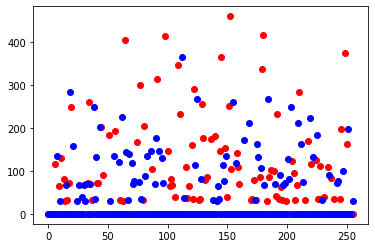

 128  256
256 10 128 28 28
torch.Size([256, 64, 56, 56]) 
 

tensor([[ 0.0000,  6.1612, 13.0405,  9.8916,  6.5166],
        [ 6.1612,  0.0000, 28.5752, 22.7785,  3.4038],
        [13.0405, 28.5752,  0.0000,  9.7779, 21.9102],
        [ 9.8916, 22.7785,  9.7779,  0.0000, 17.0194],
        [ 6.5166,  3.4038, 21.9102, 17.0194,  0.0000]], device='cuda:0')
tensor([180.5667, 103.2915,   0.0000,   0.0000,   0.0000,   0.0000,  77.8711,
          0.0000, 107.2514,  38.8227,   0.0000,  67.5177, 119.8762,   0.0000,
         79.7314,   0.0000, 120.6293,  80.5832,  76.7641,  39.7725,  34.1551,
        118.7832,  33.1421,   0.0000,   0.0000,   0.0000,  35.9192,   0.0000,
        216.5106,   0.0000,  71.5891,  38.7864,   0.0000,   0.0000,   0.0000,
        123.9025, 113.3900,   0.0000,   0.0000,   0.0000, 100.2722,   0.0000,
          0.0000, 174.6474,  33.4714, 169.2093,   0.0000,  79.0333,  73.7008,
        119.0436,  66.3190,  36.6163,  73.4917,   0.0000,  45.8507, 103.3506,
          0.0000,   0.

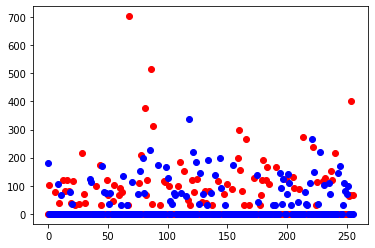

 143  256
256 10 128 28 28
torch.Size([256, 64, 56, 56]) 
 

tensor([[ 0.0000,  1.5192,  0.5827,  6.5788, -6.6759],
        [ 1.5192,  0.0000,  1.1999,  3.9993, -7.7186],
        [ 0.5827,  1.1999,  0.0000, 13.8998, -0.3748],
        [ 6.5788,  3.9993, 13.8998,  0.0000,  6.1342],
        [-6.6759, -7.7186, -0.3748,  6.1342,  0.0000]], device='cuda:0')
tensor([  0.0000,   0.0000, 220.9866,   0.0000,   0.0000,   0.0000,  70.9249,
          0.0000,   0.0000,   0.0000, 125.3748, 247.0006, 311.8808,  69.0225,
          0.0000, 110.8569, 306.5250,   0.0000, 162.5636, 206.6879,   0.0000,
        336.0609,   0.0000, 317.0280,  31.4616, 129.7057,   0.0000,   0.0000,
          0.0000,   0.0000, 116.9842,  96.6610,  64.0451, 119.2715,  30.8690,
         33.3484, 178.3624, 160.0972, 220.7698,  91.4891, 184.0368,  35.3442,
         61.7870, 244.8621,  38.1551, 277.5581,  97.6483,  49.9838,  32.2735,
          0.0000,  74.7913,   0.0000, 310.9083, 155.3619,   0.0000, 256.4518,
         32.2114,  37.

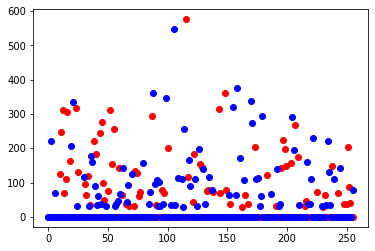

 130  256
256 10 128 28 28
torch.Size([256, 64, 56, 56]) 
 

tensor([[ 0.0000, 10.3577,  8.9805, 15.4870,  3.0522],
        [10.3577,  0.0000, 13.3867, 26.6325,  6.2138],
        [ 8.9805, 13.3867,  0.0000, 13.6721,  6.6883],
        [15.4870, 26.6325, 13.6721,  0.0000, 20.5391],
        [ 3.0522,  6.2138,  6.6883, 20.5391,  0.0000]], device='cuda:0')
tensor([125.3171,  90.6405,   0.0000,   0.0000,  81.8290,  31.9967,   0.0000,
          0.0000,  97.0187, 222.2578,   0.0000, 115.3306,  40.5699, 164.5273,
          0.0000,  36.0137,   0.0000,   0.0000,  36.8095, 325.5939, 182.8133,
        167.8374,  90.2058, 104.1066,   0.0000,   0.0000,  30.5970,   0.0000,
        291.6786,   0.0000,   0.0000, 138.2815, 205.9165,   0.0000,   0.0000,
        438.9066,  30.9602,  68.1233,  31.3247,   0.0000,   0.0000,   0.0000,
        133.1077,   0.0000, 184.7451, 414.8593,  40.1393,  39.5432,  68.5674,
        183.9909,   0.0000, 136.1947,   0.0000,   0.0000, 124.0300,   0.0000,
        102.8733, 223.

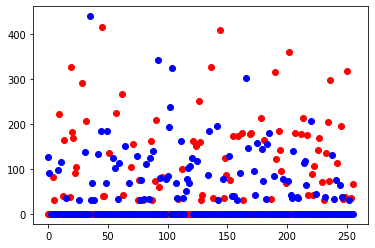

 77  156
156 10 128 28 28
torch.Size([156, 64, 56, 56]) 
 

tensor([[ 0.0000,  2.4549,  7.6590,  3.4700,  1.5864],
        [ 2.4549,  0.0000, 10.8830, -3.4538,  4.2982],
        [ 7.6590, 10.8830,  0.0000, 13.2334, 11.4440],
        [ 3.4700, -3.4538, 13.2334,  0.0000,  7.6152],
        [ 1.5864,  4.2982, 11.4440,  7.6152,  0.0000]], device='cuda:0')
tensor([  0.0000, 223.8102,  70.5036,  87.8712,   0.0000,   0.0000, 142.3183,
          0.0000,  31.5508,  30.4907,   0.0000, 300.4087, 307.1461, 241.4585,
          0.0000,   0.0000, 122.0928,   0.0000,   0.0000,  35.0354,  33.6999,
          0.0000,  38.8309, 319.7688,   0.0000,  32.5056,  74.5270,  68.4201,
        182.2359,  96.7281,   0.0000,  31.5415, 158.4020, 107.9913,   0.0000,
         31.1614, 171.9280,   0.0000, 156.3801, 107.0399,   0.0000, 132.3835,
          0.0000,  74.4399, 195.8363, 281.9629, 374.5444,   0.0000,  77.9781,
        130.2948,   0.0000,   0.0000, 124.6437,   0.0000,  43.9730,   0.0000,
          0.0000,  80.2

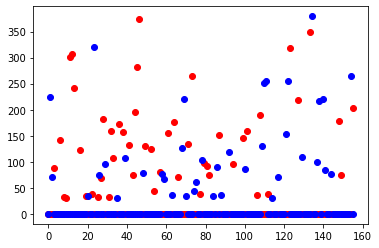

Average of good threshold=  [ 1.         54.13862228]


 best_cases:
 [[ 1.         45.3125    ]
 [ 1.         51.171875  ]
 [ 1.         58.59375   ]
 [ 1.         56.640625  ]
 [ 1.         58.97436142]]
Average of good threshold=  [ 1.         54.13862228]


In [21]:
evaluate = Inference_P3()
acc_history,best_cases=evaluate.test(estm,val_loader)

print('\n\n best_cases:\n',best_cases)
print("Average of good threshold= ",np.average(best_cases,axis=0))

In [0]:
class Inference():
  def get_preds(self,cs,model_estm,cs_thresh=2):
    score_tensor=torch.zeros((cs.shape[0],5,5),device=global_device,dtype=global_dtype)
    score_tensor2=torch.zeros((cs.shape[0]),device=global_device,dtype=global_dtype)
    
    for i in range(cs.shape[1]):
      output1 = model_estm(cs[:,i].cuda()).squeeze()
      output = output1[:, 1]
      if i == 0:
        score_tensor[:,0,1] = output
        score_tensor[:,1,0] = output
      if i == 1:
        score_tensor[:,0,2] = output
        score_tensor[:,2,0] = output
      if i == 2:
        score_tensor[:,0,3] = output
        score_tensor[:,3,0] = output
      if i == 3:
        score_tensor[:,0,4] = output
        score_tensor[:,4,0] = output
      if i == 4:
        score_tensor[:,1,2] = output
        score_tensor[:,2,1] = output
      if i == 5:
        score_tensor[:,1,3] = output
        score_tensor[:,3,1] = output
      if i == 6:
        score_tensor[:,1,4] = output
        score_tensor[:,4,1] = output
      if i == 7:
        score_tensor[:,2,3] = output
        score_tensor[:,3,2] = output
      if i == 8:
        score_tensor[:,2,4] = output
        score_tensor[:,4,2] = output
      if i == 9:
        score_tensor[:,3,4] = output
        score_tensor[:,4,3] = output

    for j in range(cs.shape[0]):
      tmp = score_tensor[j]
      score_tensor2[j] = torch.sum(tmp[tmp > cs_thresh]) #cs_thresh is 15
    
    score_tensor = torch.softmax(output1, dim=1)
    new_tensor = score_tensor2

    score = (score_tensor2 > 120).to(dtype=torch.long)
    # SCORE
    print('new_tensor[0:4] ',new_tensor[0:4])
    print('new_tensor[5:10] ',new_tensor[5:10])
    print('max and min of score',torch.max(score).item(),torch.min(score).item())

    return score,score_tensor

  def get_preds_40(self,cs,model_estm,cs_thresh=2):

    score_tensor=torch.zeros((cs.shape[0],cs.shape[1]),device=global_device,dtype=global_dtype)
    for i in range(cs.shape[1]):
      output = model_estm(cs[:,i].cuda()).squeeze()
      score_tensor[:,i] = model_estm(cs[:,i].cuda()).squeeze()

    new_tensor=torch.mean(score_tensor,dim=1)+0.5
    # print(new_tensor)
    score = new_tensor
    return score,score_tensor

  def check_acc(self,preds,y):
    preds=preds.to(torch.long)
    y=y.to(torch.long)
    # print(preds)

    accurate_labels_positive = torch.sum((preds == 0) * (y==0))
    accurate_labels_negative = torch.sum((preds == 1) * (y==1))
        
    accurate_labels = accurate_labels_positive + accurate_labels_negative
    all_labels = y.shape[0]
  
    acc = 100.0 * accurate_labels / all_labels
    return acc.item()

  def test(self,model_cs,model_estm,loader):
    model_cs.eval()
    model_estm.eval()
    extr=Extractor()
    acc_history = []
    best_cases= []
    a_list = []
    b_list = []
    y_list = []
    pred_list = []
    with torch.no_grad():
      best_acc=[] #purposefully reset for each new batch.
      for batch_id,(x,y) in enumerate(loader):
        x=x.cuda()
        y=y.cuda().to(torch.long)
        print(F" {torch.sum(y==0)}  {y.shape[0]}")
        score1=torch.sigmoid(model_cs(x))
        pred1 = score1

        patch_sizes=[(28,28)]
        num_patches=[5]

        cs = extr.batchwise_extr(x, patch_sizes=patch_sizes, num_patches= num_patches, \
                                 out_size=(28,28),b_size=128,version="AllPairs",verbose=False)
         
        score2,score2_tensor = self.get_preds(cs,model_estm,cs_thresh=15)        
        pred2 =score2
        
        print(F"{score1[0]} | {pred1[0]} |  {score2[0]} |{y[0]}")
        print(F"{score1[5]} | {pred1[5]} |  {score2[5]} |{y[5]}")

        mode = 'OR'
        t = 0.42
        
        pred = pred1*2/3+pred2/3
        a = y*pred
        b = (1-y)*pred
        a_list.extend(a.cpu())
        b_list.extend(b.cpu())
        y_list.extend(y.cpu())
        print(f"average real: {b[b!=0].mean()}")
        print(f"average fake: {a[a!=0].mean()}")
        pred = (pred>t).to(dtype=torch.long)
        pred_list.extend(pred.cpu())
        if batch_id==0:
          print(pred1.shape,pred2.shape,pred.shape)
        

        acc=self.check_acc(pred,y)
        acc_history.append([t,1-t,acc])
        print("Weightage of classifier = %f, consistency estimator = %f,accuracy = %f"%(t, 1-t,acc))

        best_acc.append(acc)
        best_threshold = t
        best_mode = mode
        plt.plot(a.cpu(), 'ro')
        plt.plot(b.cpu(), 'bo')
        plt.show()
        
      best_cases.append([best_acc,best_threshold,best_mode,batch_id])

    return acc_history,best_cases, a_list, b_list, pred_list, best_acc, y_list

 125  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([ 30.8932, 117.3853,  45.2822,   0.0000], device='cuda:0')
new_tensor[5:10]  tensor([  0.0000,  65.8769, 133.9943,  62.5176,   0.0000], device='cuda:0')
max and min of score 1 0
0.6550527215003967 | 0.6550527215003967 |  0 |1
0.4982565939426422 | 0.4982565939426422 |  0 |1
average real: 0.33220410346984863
average fake: 0.45561036467552185
torch.Size([256]) torch.Size([256]) torch.Size([256])
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 67.187500


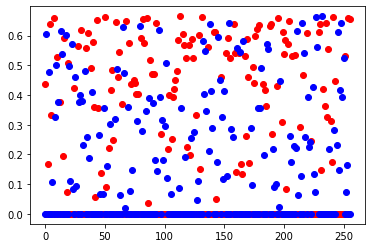

 129  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([  0.0000,  31.8827, 150.2667,   0.0000], device='cuda:0')
new_tensor[5:10]  tensor([172.4337,   0.0000,  44.7095, 118.1778,   0.0000], device='cuda:0')
max and min of score 1 0
0.48532310128211975 | 0.48532310128211975 |  0 |1
0.5049768090248108 | 0.5049768090248108 |  1 |1
average real: 0.3287428617477417
average fake: 0.46163618564605713
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 66.015625


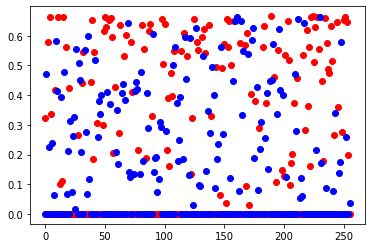

 133  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([109.7235, 142.2355,   0.0000,   0.0000], device='cuda:0')
new_tensor[5:10]  tensor([  0.0000,   0.0000, 161.4298, 151.7383, 241.4967], device='cuda:0')
max and min of score 1 0
0.38824206590652466 | 0.38824206590652466 |  0 |0
0.7705548405647278 | 0.7705548405647278 |  0 |1
average real: 0.32114654779434204
average fake: 0.48314201831817627
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 71.093750


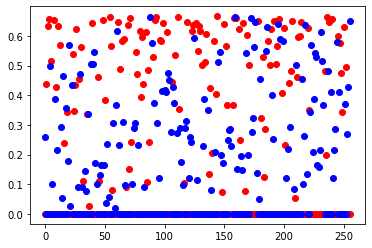

 132  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([249.6303,   0.0000,   0.0000,  41.0596], device='cuda:0')
new_tensor[5:10]  tensor([153.5610, 114.6380,   0.0000,  35.2829,   0.0000], device='cuda:0')
max and min of score 1 0
0.9601643085479736 | 0.9601643085479736 |  1 |0
0.3985639810562134 | 0.3985639810562134 |  1 |0
average real: 0.3642021119594574
average fake: 0.44636270403862
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 59.375000


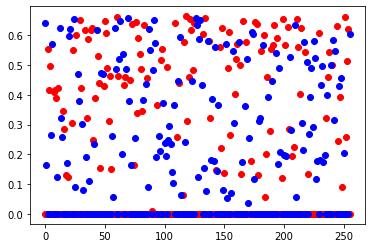

 117  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([146.4160,  84.7023, 302.3468, 109.9030], device='cuda:0')
new_tensor[5:10]  tensor([115.3797,   0.0000,   0.0000,   0.0000, 233.2349], device='cuda:0')
max and min of score 1 0
0.5160808563232422 | 0.5160808563232422 |  1 |0
0.8377113938331604 | 0.8377113938331604 |  0 |0
average real: 0.33684489130973816
average fake: 0.4461399018764496
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 61.328125


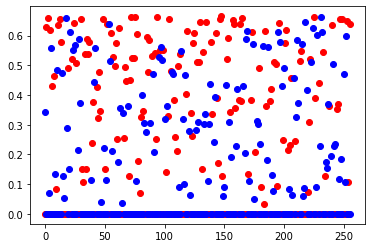

 125  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([ 81.8545,  33.0907,   0.0000, 181.2714], device='cuda:0')
new_tensor[5:10]  tensor([  0.0000,   0.0000, 136.2853,  35.3695, 110.2986], device='cuda:0')
max and min of score 1 0
0.06350144743919373 | 0.06350144743919373 |  0 |0
0.27126380801200867 | 0.27126380801200867 |  0 |0
average real: 0.3108554780483246
average fake: 0.4532049000263214
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 64.843750


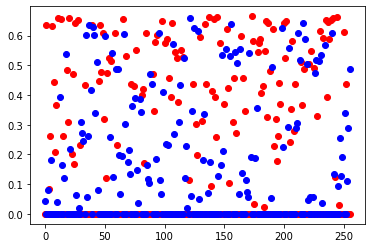

 127  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([  0.0000,  67.6563, 280.2988,  66.0483], device='cuda:0')
new_tensor[5:10]  tensor([  0.0000,   0.0000, 121.0801,   0.0000,  73.1547], device='cuda:0')
max and min of score 1 0
0.4732280969619751 | 0.4732280969619751 |  0 |1
0.34974145889282227 | 0.34974145889282227 |  0 |0
average real: 0.3408328592777252
average fake: 0.46882665157318115
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 66.796875


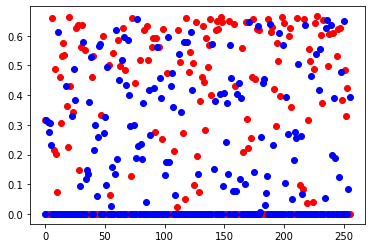

 136  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([  0.0000,   0.0000,  61.1507, 108.7256], device='cuda:0')
new_tensor[5:10]  tensor([261.3454, 421.0002,  66.6313,   0.0000,  74.3499], device='cuda:0')
max and min of score 1 0
0.8191633820533752 | 0.8191633820533752 |  0 |0
0.9794374108314514 | 0.9794374108314514 |  1 |1
average real: 0.3462066352367401
average fake: 0.4431242346763611
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 62.109375


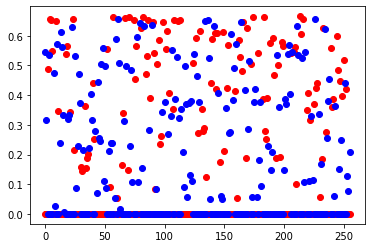

 126  256
256 10 128 28 28
inside for loop,t=   0 128
idx_range 0 127 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
inside for loop,t=   1 128
idx_range 128 255 128
torch.Size([128, 64, 56, 56]) 
 

patch_extracted
t at the end =  2 256 256
new_tensor[0:4]  tensor([192.8123,   0.0000,   0.0000,   0.0000], device='cuda:0')
new_tensor[5:10]  tensor([ 33.1202, 189.8918,   0.0000,  91.8750,   0.0000], device='cuda:0')
max and min of score 1 0
0.958293080329895 | 0.958293080329895 |  1 |1
0.4842950403690338 | 0.4842950403690338 |  0 |1
average real: 0.3083297312259674
average fake: 0.46632957458496094
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 69.140625


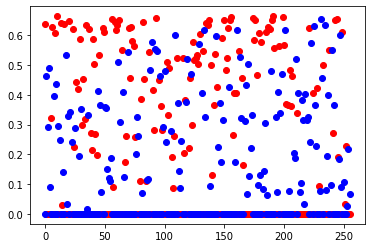

 30  56
56 10 128 28 28
torch.Size([56, 64, 56, 56]) 
 

new_tensor[0:4]  tensor([124.5930,  87.1195,   0.0000, 108.8202], device='cuda:0')
new_tensor[5:10]  tensor([ 30.5044, 149.8602,  37.8156,   0.0000,  32.7941], device='cuda:0')
max and min of score 1 0
0.2052740901708603 | 0.2052740901708603 |  1 |1
0.3739365041255951 | 0.3739365041255951 |  0 |0
average real: 0.3605421483516693
average fake: 0.4884739816188812
Weightage of classifier = 0.420000, consistency estimator = 0.580000,accuracy = 64.285721


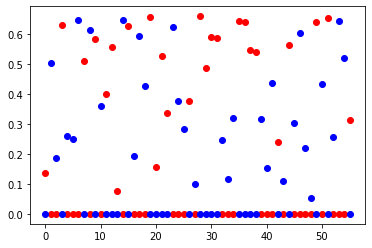

In [29]:
evaluate = Inference()

acc_history,best_cases, a_list, b_list, pred_list, best_acc, y_list = evaluate.test(imcls,estm,test_loader)

accurate_labels_positive = torch.sum((torch.tensor([pred_list]).to(torch.long) == 0) * (torch.tensor([y_list]).to(torch.long)==0))
accurate_labels_negative = torch.sum((torch.tensor([pred_list]).to(torch.long) == 1) * (torch.tensor([y_list]).to(torch.long)==1))

accurate_labels = accurate_labels_positive + accurate_labels_negative

all_labels = len(y_list)

acc = 100.0 * accurate_labels / all_labels

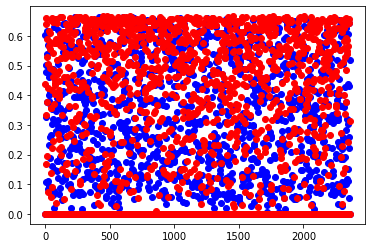

Average Accuracy: 65.2966079711914


In [32]:
plt.plot(b_list, 'bo')
plt.plot(a_list, 'ro')

plt.show()

print(f'Average Accuracy: {acc}')